## Learning goals: Learn to quantitatively assess digital images using Python:
Learn to quantitatively assess digital images using Python, including making
line and column plots, computing RMS from selected regions; read and write FITS files in
Python; compute gain and readnoise from data; remove bias levels by fitting overscan regions
and trim images.

In [169]:
#import packages 
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib as mpl
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import glob
import sys
path_dir = '/Users/mcgowkb1/ASTR8060/astr_8060_f23/software/ccd-reduction-and-photometry-guide/ccd-reduction-and-photometry-guide/notebooks/'
sys.path.insert(0,path_dir)
from convenience_functions import show_image

# Examining Images in DS9
Examine the images in DS9 to become familiar with where the overscan region of the
chip is (on both sides of the data section; make note of where this is). Examples of bias images, dark images, and flats: https://astrobasics.de/en/basics/bias-flats-darks-darkflats/

- a005-010 are SkyFlats
- a093-111 are Bias 
- d001-015 are Darks
  

# Opening Images with Python

In [170]:
# Data Directory for Images folder

data_dir = '/Users/mcgowkb1/ASTR8060/Imaging/' #raw data 
reduced_dir = '/Users/mcgowkb1/ASTR8060/astr_8060_f23/reduced_data/10102023/' #processed data

In [171]:
# Create file/image IDs for each type

# ID for flats a005-010
flat_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(5,11)]
print(flat_id)
# ID for flats a011-063
flat2_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(11,64)]

# ID for PG1633+099 images a064-092
target1_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(64,93)]
#print(images_id)

# ID for bias a093-111
bias_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(93,112)]
#print(bias_id)

# ID for darks d001-015 (skip)
darks_id = ['d'+ str(num).zfill(3) + '.fits' for num in np.arange(1,16)]
#print(darks_id)

# ID for PG1633 images a130-139
target2a_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(130,140)]
#print(images_id)

# ID for PG1633 images a202-211
target2b_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(202,212)]
#print(images_id)

# ID for PG1633 images a221-246
target2c_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(221,247)]
#print(images_id)

# ID for NGC6823 images a153-163
target3_id =  ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(153,164)]


['a005.fits', 'a006.fits', 'a007.fits', 'a008.fits', 'a009.fits', 'a010.fits']


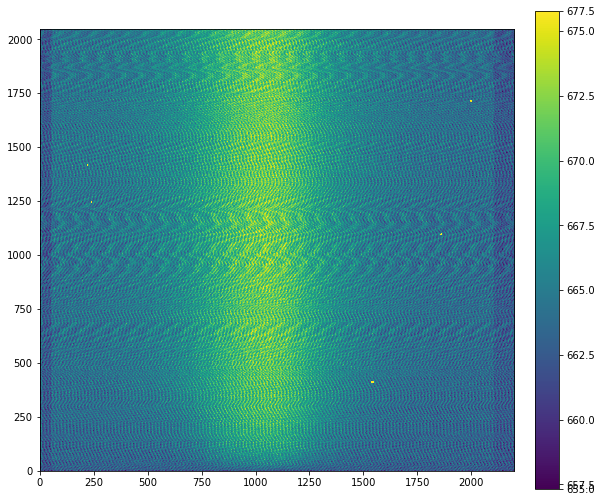

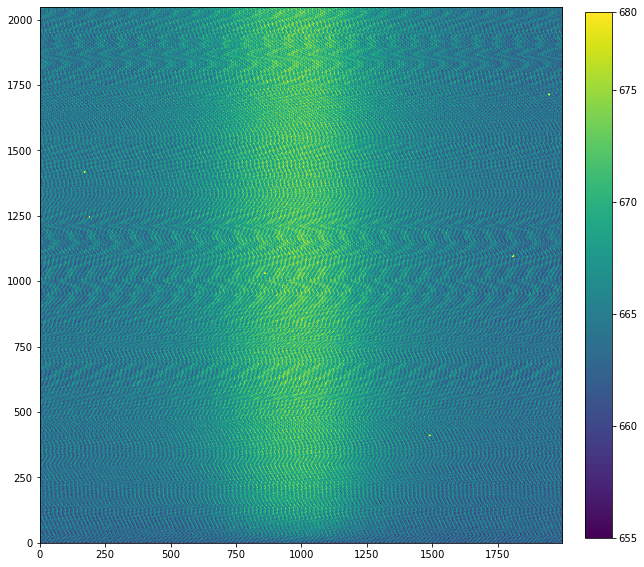

In [172]:
# Bias Sample 
hdu = fits.open(data_dir + 'a093.fits')
img = hdu[0].data
np.shape(img)
section = img[:,50:2048]
show_image(img)# before subtraction 
show_image(section)# after subtraction

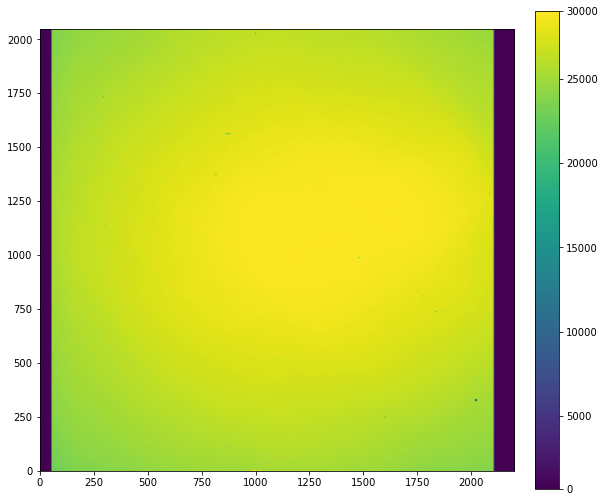

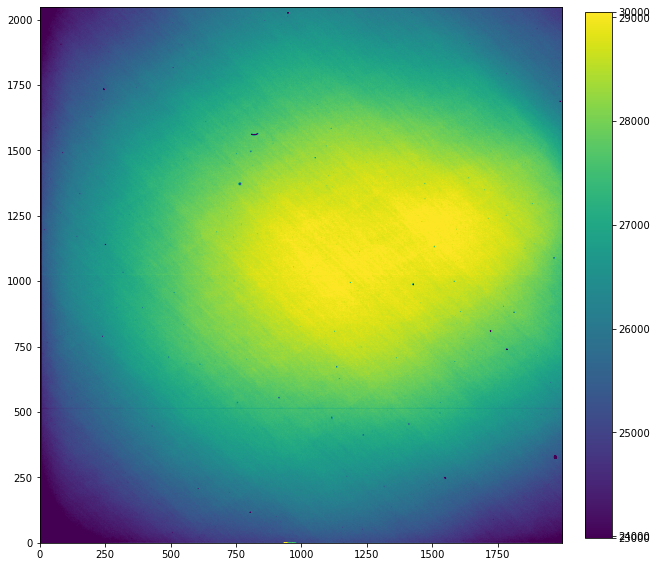

In [173]:
# Flats Sample 
hdu = fits.open(data_dir + 'a010.fits')
img = hdu[0].data
np.shape(img)
section = img[:,50:2048]
show_image(img)# before subtraction 
show_image(section)# after subtraction

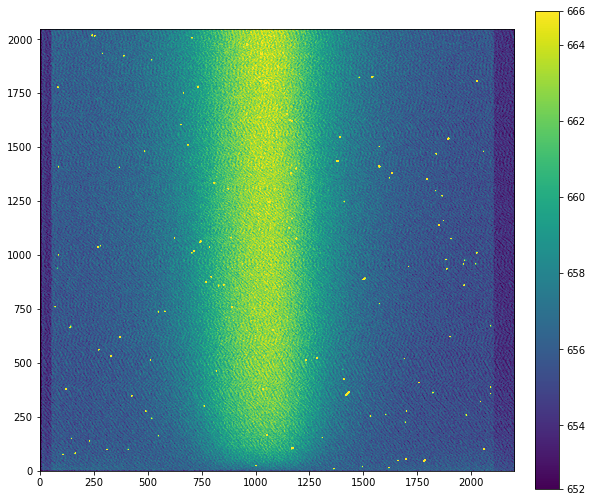

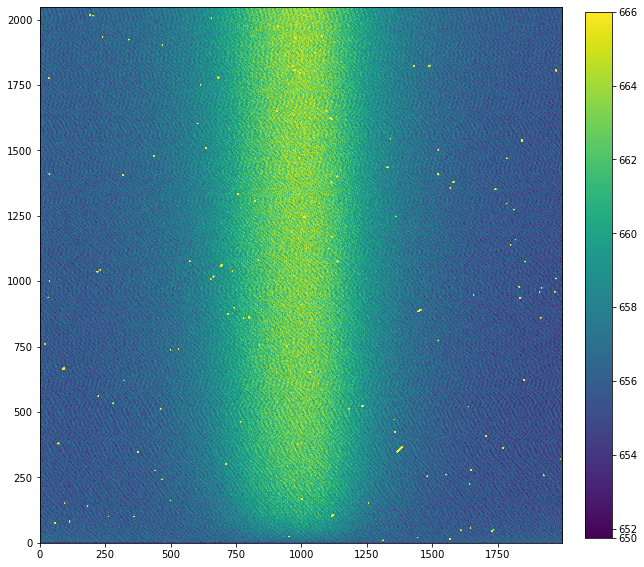

In [174]:
# darks Sample 
hdu = fits.open(data_dir + 'd015.fits')
img = hdu[0].data
np.shape(img)
section = img[:,50:2048]
show_image(img)# before subtraction 
show_image(section)# after subtraction

We can note the overscan region is section 0,50 on the left and 2048 to the end of the image. 

# Accessing the RMS and Mean of an image
Assess the RMS and mean levels of an image. Use Python to practice plotting lines and
columns of data from one of the bias images. Use Python to compute the mean and RMS
of a region near the center of the chip.

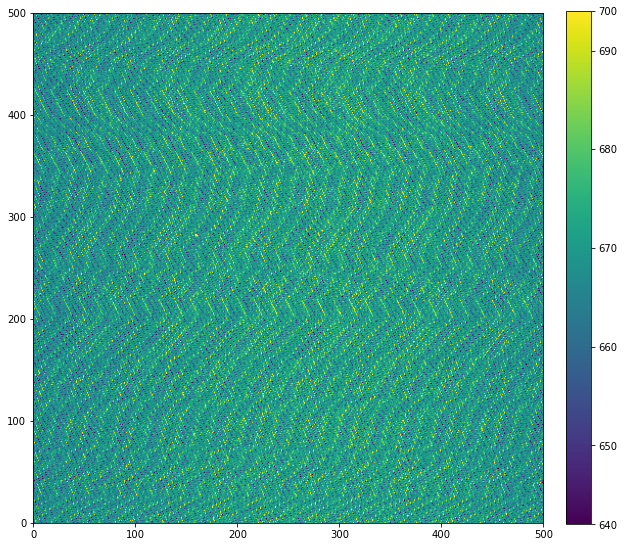

In [175]:
# Lets use the bias example 
# Bias Sample 
hdu = fits.open(data_dir + 'a093.fits')
img = hdu[0].data

np.shape(img)
section = img[:,50:2048]
hdr = hdu[0].header
#show_image(section)
#hdu.info()
#hdr

# Center image 
center_section = img[750:1250,750:1250]
show_image(center_section)

In [176]:
img_rms = np.std(center_section)
img_mean = np.mean(center_section)
print('center image RMS:',img_rms,'center image mean:',img_mean)

center image RMS: 8.784649092360148 center image mean: 670.190064


## Evaluate Bias Exposures & Overscan Regions to Determine the Bias Subtraction Method 

Examine the all bias exposures (or overscan regions throughout the night) and quantify
how much the bias level changes throughout the night. Compare the mean level of the
biases to the mean levels of the overscan regions from other files throughout the night.
How much variation do you find? Make an argument for whether it would be a good or
bad idea to combine all of the biases to make a master bias and subtract that from all the
images versus using the overscan region of each image as an estimate of the bias level.

In [177]:
# a093-111 are Bias 
bias_means = []
trim_means = []
for ids in bias_id:
    hdu = fits.open(data_dir + ids)
    img = hdu[0].data
    bias_sec = img[:,2100:2199] #overscan regions
    trim_sec = img[:,50:2048]  #science regions 
    bias_mean = np.mean(bias_sec)
    science_mean = np.mean(trim_sec)
    bias_means.append(bias_mean)
    trim_means.append(science_mean)
    

print(bias_means)
print(np.mean(bias_means))

print(trim_means)
print(np.mean(trim_means))
#hdu.info()
#hdr = hdu[0].header
#hdr
#mean value of overscan region vs row number 
#each row gets 1 average overscan  

[662.6044231376262, 662.2916765309343, 662.3431828046085, 662.443541863952, 662.442565301452, 662.439423532197, 662.3853574810606, 662.3316564078283, 662.3642726089015, 662.326201467803, 662.3430644333964, 662.3391137941919, 662.3369584517045, 662.3923808396464, 662.3348770912247, 662.3629655934343, 662.3785067471591, 662.4254705255681, 662.418792416351]
662.3844437383706
[666.1347969062813, 665.8049130673643, 665.8597997411474, 665.9729917906187, 665.9631039731138, 665.9376063074793, 665.8916194026058, 665.8516160203172, 665.8775809500908, 665.8454235485485, 665.8634833564033, 665.8526199539383, 665.8491692375969, 665.8885132691285, 665.839160938282, 665.9042841669794, 665.8966635092123, 665.9291882214245, 665.9339671702953]
665.8998158700435


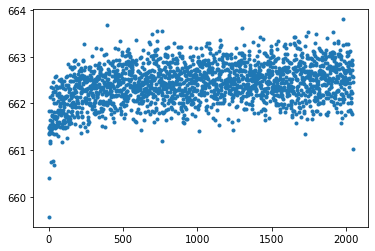

In [178]:
overscan_avg = np.mean(bias_sec,axis=1)
row = np.arange(0,2048)
plt.plot(row,overscan_avg,'.')

Model: Chebyshev1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 6
Domain: (0.0, 2047.0)
Parameters:
            c0                 c1         ...          c6         
    ----------------- ------------------- ... --------------------
    662.3389794856374 0.32120002644407547 ... -0.04722347006562343
Model: Legendre1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 6
Domain: (0.0, 2047.0)
Parameters:
            c0                 c1         ...          c6         
    ----------------- ------------------- ... --------------------
    662.4190079950135 0.22897679392842038 ... -0.10466847044868312
0.38619955099974235 Chebyshev RMS
0.38619955099974257 Legendre RMS


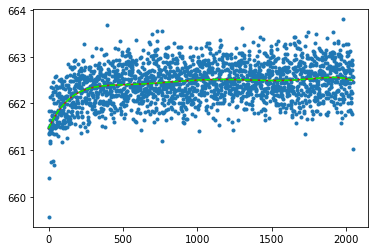

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.optimize
# Make plots display in notebook
%matplotlib inline

model_cheb = models.Chebyshev1D(degree=6)
model_legd = models.Legendre1D(degree=6)

model1 = model_cheb
model2 = model_legd

fitter = fitting.LinearLSQFitter() 
best_fit1 = fitter(model1,row,overscan_avg)
best_fit2 = fitter(model2,row,overscan_avg)
print(best_fit1)
print(best_fit2)

plt.plot(row,overscan_avg,'.')
plt.plot(row,best_fit1(row), linestyle = '-',c='firebrick')
plt.plot(row,best_fit2(row), linestyle = '--',c='lime')

new_rms1 = np.std(overscan_avg - best_fit1(row))
new_rms2 = np.std(overscan_avg - best_fit2(row))
print(new_rms1, 'Chebyshev RMS')
print(new_rms2, 'Legendre RMS')

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
           c0                  c1          ...           c3         
    ---------------- --------------------- ... ---------------------
    661.801691970807 0.0018932883444609824 ... 4.231554247931266e-10
Model: Hermite1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Domain: (0.0, 2047.0)
Parameters:
            c0                c1                  c2                   c3         
    ----------------- ------------------ -------------------- --------------------
    662.3672445452044 0.3187267008844003 -0.07747319547660335 0.056711804581159556
0.39100201018472597 Polynomial RMS
0.3910020101847264 Hermite RMS


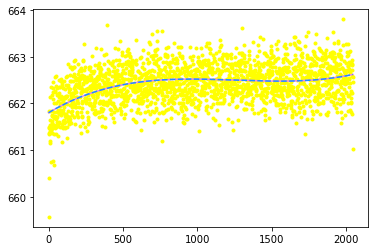

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.optimize
# Make plots display in notebook
%matplotlib inline


model_poly = models.Polynomial1D(degree=3)
model_herm = models.Hermite1D(degree=3)

model3 = model_poly
model4 = model_herm

fitter = fitting.LinearLSQFitter() 
best_fit1 = fitter(model3,row,overscan_avg)
best_fit2 = fitter(model4,row,overscan_avg)
print(best_fit1)
print(best_fit2)

plt.plot(row,overscan_avg,'.',color = 'yellow')
plt.plot(row,best_fit1(row), linestyle = '-',c='violet')
plt.plot(row,best_fit2(row), linestyle = '--',c='dodgerblue')

new_rms1 = np.std(overscan_avg - best_fit1(row))
new_rms2 = np.std(overscan_avg - best_fit2(row))
print(new_rms1, 'Polynomial RMS')
print(new_rms2, 'Hermite RMS')

Using CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE, fit and subtract the overscan
region of each image and trim the image to remove the overscan region. In the
overscan fitting, try out ’chebyshev’, ’legendre’, and ’hermite’, and ’polynomial’ of various
orders for the fitting function. Qualitatively try to summarize the differences between
the functions (you can also look up and summarize the properties of these types of polynomials,
but this is not required). Also try orders 1 through about 8, and make an argument
for how large an order is necessary to fit the overscan region.

In [181]:
from astropy.nddata import CCDData
from tempfile import mkdtemp
from pathlib import Path
from ccdproc import ImageFileCollection, Combiner, combine

# Make a temporary folder as a path object
image_folder = Path(mkdtemp())


# Overscan Subtraction
for ids in bias_id:
    #hdu = fits.open(data_dir + ids)
    #img = hdu[0].data
    img = CCDData.read(data_dir + ids, hdu=0, unit="adu")
    #bias_sec = img[:,2100:2199] #overscan regions
    #trim_sec = img[:,50:2048] #science regions
    img_ot = ccdp.subtract_overscan(img,fits_section='[2141:2200,1:2048]', model = model1) #rows and columns flipped
    img_otz = ccdp.trim_image(img_ot[:,50:2098]) #check size/shape
    img_otz.write(image_folder/f'otz_{ids}',overwrite=True)

ifc = ImageFileCollection(image_folder)
#ifc.summary
#pg1633 ngc6823 flats and bias 
#overscan subtracted 
#bias subtracted 
#trimmed 2048x2048 

Combine the bias frames into a master bias frame using CCDPROC.COMBINE. By visual
inspection or using image statistics, decide whether it is appropriate to combine all your
bias exposures to make 1 master bias, or whether you need to restrict the input frames
because of variations among your bias frames. Are there trends in your sequence of bias
frames? Does either the level, or the pattern of the bias change throughout the night? If
so, by how much? How much noise would you be adding to your data if you decide to do
a bias subtraction in addition to your overscan subtraction. Do the subtraction of your
master bias from all other science frames if you can justify that it is warranted.

(2048, 2048)


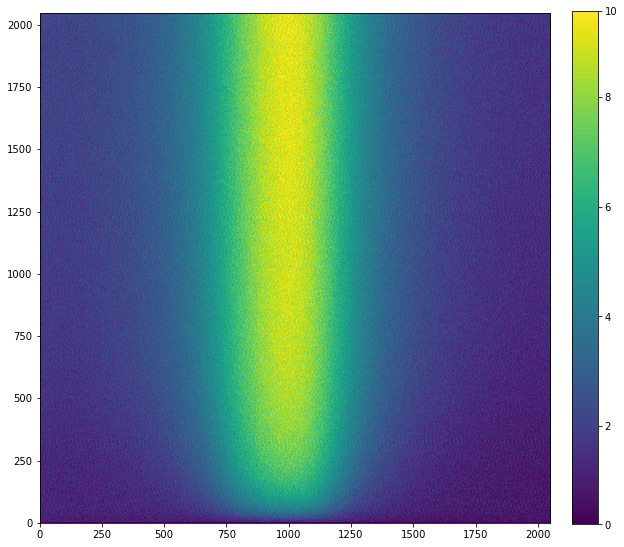

In [182]:
avg_combo = combine(ifc.ccds(),method = 'median')
show_image(avg_combo)
master_bias = avg_combo
print(np.shape(avg_combo))

In [183]:
# Prep the science frames. They must be overscan subtracted and trimmed before we can subtract the master bias 

In [184]:
def processing_function(image_ids):

    # Make a temporary folder as a path object
    prep_folder = reduced_dir

    # Overscan Subtraction and trim prepping for master bias subtraction 
    for ids in image_ids:
        img = CCDData.read(data_dir + ids, hdu=0, unit="adu")
        img_ot = ccdp.subtract_overscan(img,fits_section='[2141:2200,1:2048]', model = model1) #rows and columns flipped
        img_otz = ccdp.trim_image(img_ot[:,50:2098]) #check size/shape
        no_bias_frame = ccdp.subtract_bias(img_otz, master_bias) 
        no_bias_frame.write(reduced_dir + f'otz_{ids}',overwrite=True)

    #ifc = ImageFileCollection(prep_folder)
    return 

In [185]:
processing_function(flat_id)
processing_function(flat2_id)
processing_function(target1_id)
processing_function(target1_id)
processing_function(target2a_id)
processing_function(target2b_id)
processing_function(target2c_id)
processing_function(target3_id)

/Users/mcgowkb1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mcgowkb1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


LinAlgError: SVD did not converge in Linear Least Squares

Now examine the ‘dark’ images quantitatively and estimate the range of dark current
(electrons per pixel per second) you see in the darks. WIRO Prime’s gain is 2.5 e􀀀/ADU.
Use Python to inspect the header and see the exposure time in each of the darks. Pixel
values will vary! Be careful to avoid being fooled by cosmic rays, which will appear as
large bright spots usually spread over a few pixels, whereas high dark current is usually
isolated to just individual pixels.

Use CCDPROC.COMBINE to combine darks together to make a master dark. You will need
to play with different combination parameters to see which one does the best job of
eliminating cosmic rays. At a minimum, do

- A straight average of all dark frames.
- A straight median of all dark frames.
- An average where outlier pixels are rejected if they are more than 3  away from the
mean.
- A median where outlier pixels are rejected if they are more than 3  away from the
mean.

Use the resulting RMS in the master image as an indicator of which combination procedure
is best. Compare your master dark to your master bias to estimate the significance of the
highest dark count pixels. How many times larger is the typical dark current than the
noise ( ) in the master image?